In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()

In [2]:
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = "/data/chuanleiguo/data/hymenoptera_data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                         data_transforms[x])
                  for x in ["train", "val"]}
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ["train", "val"]}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes

use_gpu = torch.cuda.is_available()

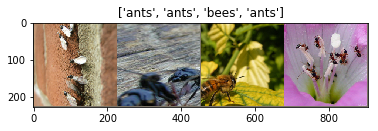

In [3]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
inputs, classes = next(iter(dataloders["train"]))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)
        
        for phase in ["train", "val"]:
            if phase == "train":
                scheduler.step()
                model.train(True)
            else:
                model.train(False)
                
            running_loss = 0.0
            running_corrects = 0
            
            for data in dataloders[phase]:
                inputs, labels = data
                
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                
                optimizer.zero_grad()
                
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                
                if phase == "train":
                    loss.backward()
                    optimizer.step()
                    
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(
                phase, epoch_loss, epoch_acc))
            
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [10]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [11]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1462 Acc: 0.6885
val Loss: 0.0559 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.1070 Acc: 0.8156
val Loss: 0.0658 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.1007 Acc: 0.7992
val Loss: 0.0740 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.1061 Acc: 0.8443
val Loss: 0.0505 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.1086 Acc: 0.7951
val Loss: 0.0755 Acc: 0.8693

Epoch 5/24
----------
train Loss: 0.1242 Acc: 0.8238
val Loss: 0.1010 Acc: 0.8431

Epoch 6/24
----------
train Loss: 0.0988 Acc: 0.8689
val Loss: 0.0566 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.0803 Acc: 0.8566
val Loss: 0.0675 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.0969 Acc: 0.8320
val Loss: 0.0497 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.0588 Acc: 0.8934
val Loss: 0.0543 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.0641 Acc: 0.8852
val Loss: 0.0464 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.0726 Acc: 0.8811
val Loss: 0.0522 Acc: 0.9150

Ep

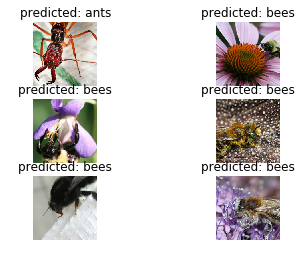

In [13]:
visualize_model(model_ft)

In [14]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [15]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1643 Acc: 0.6066
val Loss: 0.1000 Acc: 0.8170

Epoch 1/24
----------
train Loss: 0.1237 Acc: 0.7869
val Loss: 0.0423 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.0977 Acc: 0.8402
val Loss: 0.0436 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.1349 Acc: 0.7664
val Loss: 0.1123 Acc: 0.8431

Epoch 4/24
----------
train Loss: 0.1615 Acc: 0.6967
val Loss: 0.0420 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.0895 Acc: 0.8443
val Loss: 0.0451 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.1080 Acc: 0.8238
val Loss: 0.0838 Acc: 0.8693

Epoch 7/24
----------
train Loss: 0.1087 Acc: 0.8115
val Loss: 0.0459 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.0956 Acc: 0.8443
val Loss: 0.0428 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.0912 Acc: 0.8607
val Loss: 0.0486 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.0877 Acc: 0.8566
val Loss: 0.0509 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.0823 Acc: 0.8607
val Loss: 0.0534 Acc: 0.9281

Ep

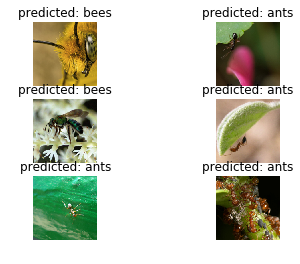

In [16]:
visualize_model(model_conv)

plt.ioff()
plt.show()